# Logistic Regression with a Neural Network mindset


代码过程整体思路：

    1）初始化参数
    2）计算成本函数和梯度
    3）实现优化算法：梯度下降


## 1 - 导入所需包 ##



In [125]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset#加载数据集

%matplotlib inline

## 2 - 分析数据集 ##

1）数据集：data.h5

    训练集：猫标签是1或0
    
    测试集：猫标签
    
    每一张图片：维度：（num_px,num_px,3) [num_px:矩阵的行和列，3:RGB三通道]
    
2) 任务：写算法判别猫

In [126]:
#自己写的，将变量词换成自己熟悉的，加载数据集作者大大已写好的函数库 ：from lr_utils import load_dataset
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5',"r")
    x_train_orig = np.array(train_dataset["train_set_x"][:])#训练集特征
    y_train_orig = np.array(train_dataset["train_set_y"][:])#训练集标签
    
    test_dataset = h5py.File('datasets/test_catvnoncat.h5',"r")
    x_test_orig = np.array(test_dataset["test_set_x"][:])#测试集特征
    y_test_orig = np.array(test_dataset["test_set_y"][:])#测试集标签
    
    classes = np.array(test_dataset["list_classes"]) 
    
    #reshape函数：改变数组的维数
    y_train_orig = y_train_orig.reshape((1,y_train_orig.shape[0]))
    y_test_orig = y_test_orig.reshape((1,y_test_orig.shape[0]))
    
    return x_train_orig,y_train_orig,x_test_orig,y_test_orig,classes

In [127]:
x_train_orig,y_train_orig,x_test_orig,y_test_orig,classes = load_dataset()

y = [0],it's a 'non-cat'picture.


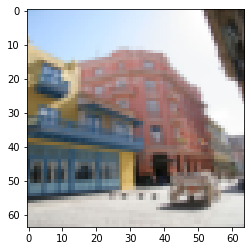

In [128]:
# 随便看一张图片
#str(y_train_orig[:,index]) : 输出猫标签是1或0
#classes[np.squeeze(y_train_orig[:,index])].decode("utf-8") : 输出类别是猫或非猫
#np.squeeze ：squeeze 函数：从数组的形状中删除单维度条目，即把shape中为1的维度去掉 
#举例：(2,1)->(2,)
#str() 函数将对象转化为适于人阅读的形式。

index = 23
plt.imshow(x_train_orig[index])
print("y = " + str(y_train_orig[:,index]) + ",it's a '" +classes[np.squeeze(y_train_orig[:,index])].decode("utf-8") + "'picture.")


3)变量解释：
    - m_train (训练集数量)
    - m_test  (测试集数量)
    - num_px  (照片:矩阵的行和列)
举例：
x_train_orig 维度：(m_train, num_px, num_px, 3)

In [129]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = x_train_orig.shape[0]
m_test =x_test_orig.shape[0]
num_px = x_train_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("x_train_orig shape: " + str(x_train_orig.shape))
print ("y_train_orig shape: " + str(y_train_orig.shape))
print ("x_test_orig  shape: " + str(x_test_orig.shape))
print ("y_test_orig  shape: " + str(y_test_orig.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
x_train_orig shape: (209, 64, 64, 3)
y_train_orig shape: (1, 209)
x_test_orig  shape: (50, 64, 64, 3)
y_test_orig  shape: (1, 50)


4）Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。Flatten不影响batch的大小。

我们将照片展平：(num_px, num_px, 3) --> (num\_px $*$ num\_px $*$ 3, 1)

训练集：m_train列

测试集：m_test列

 
```运用python处理，即
X_flatten = X.reshape(X.shape[0], -1).T      # X.T 是 X 的转置
```

In [130]:
### START CODE HERE ### (≈ 2 lines of code)
x_train_flatten = x_train_orig.reshape(x_train_orig.shape[0],-1).T
x_test_flatten = x_test_orig.reshape(x_test_orig.shape[0],-1).T
### END CODE HERE ###

print("x_train_orig    shape ：" + str(x_train_orig.shape))
print("x_train_flatten shape ：" + str(x_train_flatten.shape))
print("x_test_orig     shape ：" + str(x_test_orig.shape))
print("x_test_flatten  shape ：" + str(x_test_flatten.shape))

x_train_orig    shape ：(209, 64, 64, 3)
x_train_flatten shape ：(12288, 209)
x_test_orig     shape ：(50, 64, 64, 3)
x_test_flatten  shape ：(12288, 50)


5）归一化


In [131]:
x_train = x_train_flatten / 255
x_test  = x_test_flatten  / 255

## 3 - 算法架构 （逻辑回归） ##


<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**算法公式表示**:

1）$x^{(i)}$:

$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

2）训练集代价函数公式:

$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

3）实现算法关键步骤：

    1、初始化模型参数
    
    2、训练模型参数来求得代价函数最小值
    
    3、将训练出的参数在测试集上预测准确性
    
    4、分析结果并总结

## 4 - 建立算法部分内容 ## 

主要步骤

1. 定义模型结构 
2. 计算模型参数
3. 循环:
    - 计算损失值  (forward propagation)
    - 计算梯度值  (backward propagation)
    - 更新参数     (gradient descent)


### 4.1 - 函数

$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ 

所用numpy函数库：np.exp()

In [132]:
def sigmoid(z):
    s = 1 / (1+np.exp(-z))
    return s

In [133]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


### 4.2 -初始化参数

np.zeros() --> 初始化参数


In [134]:
def initialize_with_zeros(dim):
    
    w = np.zeros((dim,1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance (b,float)  or isinstance(b,int))
    return w, b

In [135]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


### 4.3 - 前向及后向传播

1）实现函数 `propagate()` 来计算成本和梯度


前向传播:
-  X
-  $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

参数含义：

w:权值-->(num_px * num_px * 3, 1)

b:偏置(标量）

X:数据大小(num_px * num_px * 3,m)

Y:标签向量(1,m)

所用numpy函数库:  np.log() ,  np.dot()

In [136]:
def propagate(w, b, X, Y):
    m = X.shape[1]
    #前向传播
    A = sigmoid(np.dot(w.T,X) + b)
    J = -1 * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)) / m #易错点：Y*np.log(A) --> np.dot(Y,np.log(A))
    
    #反向传播
    dw = np.dot(X,(A-Y).T) / m #重点理解公式怎么来的
    db = np.sum(A-Y) / m
    
    cost = np.squeeze(J)
    assert(cost.shape == ())
    
    grads = {"dw":dw,
             "db":db}
    
    return grads,cost
    
    

In [137]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))


dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


### 4.4 - 优化

前提条件：

    1、参数初始化
    2、代价函数和梯度
    
目的：

    用梯度下降算法来更新参数 : w,b
    
**规则:** 对于参数 $\theta$,  $ \theta = \theta - \alpha \text{ } d\theta$, $\alpha$ 是学习率.
   
    

In [138]:
#       优化三行主要代码：
#       grads,cost = propagate(w, b , X, Y)
#       w = w - learning_rate * dw
#       b = b - learning_rate * db
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    for i in range(num_iterations):
        
        grads,cost = propagate(w, b , X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db

        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads,costs

In [139]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("dw = " + str(grads["dw"]))
print ("b = " + str(params["b"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
dw = [[0.67752042]
 [1.41625495]]
b = 1.9253598300845747
db = 0.21919450454067657


### 4.5 - 预测
实现 `predict()` 函数. 
关键步骤如下：

1. 计算 $\hat{Y} = A = \sigma(w^T X + b)$

2. 预测A值
    (A < 0.5 --> 0 | A > 0.5 --> 1)

In [140]:
#def predict(w, b, X):
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)

    A = sigmoid(np.sum(w*X,axis = 0) + b).reshape(1,m)
    
    Y_prediction[A>0.5]=1
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

In [141]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


## 5 -融合至模型 ##



**Exercise:** Implement the model function. Use the following notation:
    - Y_prediction_test for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [142]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000,learning_rate = 0.5,print_cost = False):
    dim = X_train.shape[0]
    m_train = X_train.shape[1]
    #初始化参数
    w = np.zeros((dim,1))
    b = 0
    #梯度下降
    params,grads,costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = params["w"]
    b = params["b"]
    
    #预测
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test  = predict(w, b, X_test)
    
    #train/test errors
    print("train accuracy :{}%".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy : {}%".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"cost":costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train": Y_prediction_train,
         "w":w,
         "b":b,
         "learning_rate":learning_rate,
         "num_iterations":num_iterations}
    return d

In [143]:
d = model(x_train,y_train, x_test, y_test, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy :99.04306220095694%
test accuracy : 70.0%


y = 1, you predicted that it is a "cat" picture.


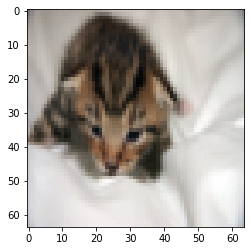

In [144]:
# d["Y_prediction_test"][0,index]:非int型，作切片索引要强制转换为int类型
index = 1
plt.imshow(x_test[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(y_test[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

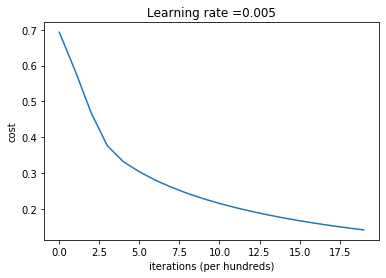

In [145]:
# 画出学习曲线
costs = np.squeeze(d['cost'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

## 6 - 进一步分析（学习率） ##


learning rate is: 0.01
train accuracy :99.52153110047847%
test accuracy : 68.0%

-------------------------------------------------------

learning rate is: 0.001
train accuracy :88.99521531100478%
test accuracy : 64.0%

-------------------------------------------------------

learning rate is: 0.0001
train accuracy :68.42105263157895%
test accuracy : 36.0%

-------------------------------------------------------



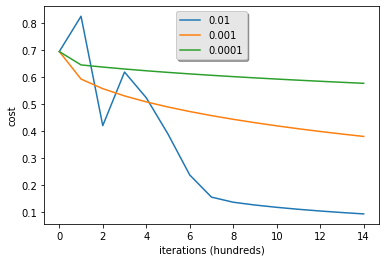

In [146]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(x_train, y_train, x_test, y_test, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["cost"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

## 7 - 用新的数据集测试 ##

y = 0.0, your L-layer model predicts a "non-cat" picture.


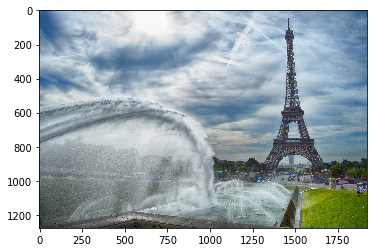

In [147]:
my_image = "my_image.jpg"
import imageio
import scipy.misc
from skimage.transform import resize
fname = "images/" + my_image
image = np.array(imageio.imread(fname))
my_image = resize(image, output_shape=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)
plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[
        int(np.squeeze(my_predicted_image)),].decode("utf-8") + "\" picture.")


Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c